In [4]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import dask.array as da
import pickle
from scipy.stats import t
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### purpose is to explore what humidity, and wind profiles look like from 0, 6 and 12 LST

In [5]:
# removes underground values, contains advections and mean wind profiles

with open('/home/annierosen16/master_clean.pkl', 'rb') as f:
    
    master = pickle.load(f)

In [6]:
# reading in ERA5 u, v, w and q

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

years = [str(year) for year in range(2001, 2019)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

# Get the files for each component

u_files = get_files('u_component_of_wind', 'u_component_of_wind')

v_files = get_files('v_component_of_wind', 'v_component_of_wind')

w_files = get_files('vertical_velocity', 'vertical_velocity')

q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files + w_files

# open all datasets at once

uvwq = xr.open_mfdataset(all_files, combine='by_coords', chunks={'time': 24})

In [34]:
# filtering for correct domain and time

# uvwq_sgp = uvwq.sel(
    
#     latitude=slice(39, 30),
    
#     longitude=slice(-105, -95)
# )

# if i want larger domain 

uvwq_sgp = uvwq.sel(
    
    latitude=slice(40, 29),
    
    longitude=slice(-106, -94)
)

uvwq_sgp['time'] = uvwq_sgp['time'] - pd.Timedelta(hours=6)

uvwq_sgp_am = uvwq_sgp.where(
    
    (uvwq_sgp.time.dt.hour.isin([0, 6, 12])) &
    
    (uvwq_sgp.time.dt.month.isin([5, 6, 7, 8, 9])) &
    
    (uvwq_sgp.time.dt.year.isin(range(2001, 2019))),
    
    drop=True
)

uvwq_sgp_am["w"] = uvwq_sgp_am["w"] * -1

In [36]:
_0lst = uvwq_sgp_am.sel(time=uvwq_sgp_am.time.dt.hour == 0)

_6lst = uvwq_sgp_am.sel(time=uvwq_sgp_am.time.dt.hour == 6)

_12lst = uvwq_sgp_am.sel(time=uvwq_sgp_am.time.dt.hour == 12)

In [43]:
## loading u, v, w and q for 0lst

_0lst_u = _0lst['u'].load().data

print("u loaded")

_0lst_v = _0lst['v'].load().data

print("v loaded")

_0lst_w = _0lst['w'].load().data

print("w loaded")

_0lst_q = _0lst['q'].load().data

print("q loaded")

u loaded
v loaded
w loaded
q loaded


In [92]:
## loading u, v, w and q for 6lst

_6lst_u = _6lst['u'].load().data

print("u loaded")

_6lst_v = _6lst['v'].load().data

print("v loaded")

_6lst_w = _6lst['w'].load().data

print("w loaded")

_6lst_q = _6lst['q'].load().data

print("q loaded")

u loaded
v loaded
w loaded
q loaded


In [93]:
## loading u, v, w and q for 12lst

_12lst_u = _12lst['u'].load().data

print("u loaded")

_12lst_v = _12lst['v'].load().data

print("v loaded")

_12lst_w = _12lst['w'].load().data

print("w loaded")

_12lst_q = _12lst['q'].load().data

print("q loaded")

u loaded
v loaded
w loaded
q loaded


In [54]:
times = _0lst['time'].data

latitude = _0lst['latitude'].data

longitude = _0lst['longitude'].data

pressure = _0lst['level'].data

### calculating average u, v, w, and q profiles for 0 LST, appending to master

In [50]:
master['0lst_u_profile'] = None

master['0lst_v_profile'] = None

master['0lst_w_profile'] = None

master['0lst_q_profile'] = None

for date in range(master.shape[0]):
        
    target_date = master['date'].iloc[date]  
    
    target_date = np.datetime64(target_date)

    # Find the index in daily_avg['time'].data
    
    date_idx = np.where(_0lst['time'].data == target_date)[0][0]

    lat_idx = master['latitude'].iloc[date]
    
    lon_idx = master['longitude'].iloc[date]

    # Define the center point and half-window (in degrees)
    
    delta = 0.5
    
    lat_mask = (latitude >= (lat_idx - delta)) & (latitude <= (lat_idx + delta))
    
    lon_mask = (longitude >= (lon_idx - delta)) & (longitude <= (lon_idx + delta))

    lat_indices = np.where(lat_mask)[0]
    
    lon_indices = np.where(lon_mask)[0]

    lat_mini = latitude[lat_indices]
    
    lon_mini = longitude[lon_indices]

    # Extract mini domains for u, v, q, w
    
    u = _0lst_u
    
    v = _0lst_v
    
    w = _0lst_w
    
    q = _0lst_q 
    
    u_mini = u[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
    
    v_mini = v[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
    
    w_mini = w[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]

    q_mini = q[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
        
    # Compute average profiles
    
    mean_u_profile = np.nanmean(u_mini, axis=(1, 2))  # Averaging over lat and lon
        
    mean_v_profile = np.nanmean(v_mini, axis=(1, 2))  # Averaging over lat and lon
    
    mean_w_profile = np.nanmean(w_mini, axis=(1, 2))  # Averaging over lat and lon

    mean_q_profile = np.nanmean(q_mini, axis=(1, 2)) # Averaging over lat and lon
        
    # Assign results to the DataFrame
    
    master.at[date, '0lst_u_profile'] = mean_u_profile
        
    master.at[date, '0lst_v_profile'] = mean_v_profile
            
    master.at[date, '0lst_w_profile'] = mean_w_profile
    
    master.at[date, '0lst_q_profile'] = mean_q_profile

### calculating average u, v, w, and q profiles for 6 LST, appending to master

In [ ]:
master['6lst_u_profile'] = None

master['6lst_v_profile'] = None

master['6lst_w_profile'] = None

master['6lst_q_profile'] = None

for date in range(master.shape[0]):
        
    target_date = master['date'].iloc[date]  
    
    target_date = np.datetime64(target_date)

    # Find the index in daily_avg['time'].data
    
    date_idx = np.where(_0lst['time'].data == target_date)[0][0]

    lat_idx = master['latitude'].iloc[date]
    
    lon_idx = master['longitude'].iloc[date]

    # Define the center point and half-window (in degrees)
    
    delta = 0.5
    
    lat_mask = (latitude >= (lat_idx - delta)) & (latitude <= (lat_idx + delta))
    
    lon_mask = (longitude >= (lon_idx - delta)) & (longitude <= (lon_idx + delta))

    lat_indices = np.where(lat_mask)[0]
    
    lon_indices = np.where(lon_mask)[0]

    lat_mini = latitude[lat_indices]
    
    lon_mini = longitude[lon_indices]

    # Extract mini domains for u, v, q, w
    
    u = _6lst_u
    
    v = _6lst_v
    
    w = _6lst_w
    
    q = _6lst_q 
    
    u_mini = u[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
    
    v_mini = v[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
    
    w_mini = w[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]

    q_mini = q[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
        
    # Compute average profiles
    
    mean_u_profile = np.nanmean(u_mini, axis=(1, 2))  # Averaging over lat and lon
        
    mean_v_profile = np.nanmean(v_mini, axis=(1, 2))  # Averaging over lat and lon
    
    mean_w_profile = np.nanmean(w_mini, axis=(1, 2))  # Averaging over lat and lon

    mean_q_profile = np.nanmean(q_mini, axis=(1, 2)) # Averaging over lat and lon
        
    # Assign results to the DataFrame
    
    master.at[date, '6lst_u_profile'] = mean_u_profile
        
    master.at[date, '6lst_v_profile'] = mean_v_profile
            
    master.at[date, '6lst_w_profile'] = mean_w_profile
    
    master.at[date, '6lst_q_profile'] = mean_q_profile

### calculating average u, v, w, and q profiles for 12 LST, appending to master

In [118]:
master['12lst_u_profile'] = None

master['12lst_v_profile'] = None

master['12lst_w_profile'] = None

master['12lst_q_profile'] = None

for date in range(master.shape[0]):
        
    target_date = master['date'].iloc[date]  
    
    target_date = np.datetime64(target_date)

    # Find the index in daily_avg['time'].data
    
    date_idx = np.where(_0lst['time'].data == target_date)[0][0]

    lat_idx = master['latitude'].iloc[date]
    
    lon_idx = master['longitude'].iloc[date]

    # Define the center point and half-window (in degrees)
    
    delta = 0.5
    
    lat_mask = (latitude >= (lat_idx - delta)) & (latitude <= (lat_idx + delta))
    
    lon_mask = (longitude >= (lon_idx - delta)) & (longitude <= (lon_idx + delta))

    lat_indices = np.where(lat_mask)[0]
    
    lon_indices = np.where(lon_mask)[0]

    lat_mini = latitude[lat_indices]
    
    lon_mini = longitude[lon_indices]

    # Extract mini domains for u, v, q, w
    
    u = _12lst_u
    
    v = _12lst_v
    
    w = _12lst_w
    
    q = _12lst_q 
    
    u_mini = u[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
    
    v_mini = v[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
    
    w_mini = w[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]

    q_mini = q[date_idx, :, :, :][:, lat_mask, :][:, :, lon_mask]
        
    # Compute average profiles
    
    mean_u_profile = np.nanmean(u_mini, axis=(1, 2))  # Averaging over lat and lon
        
    mean_v_profile = np.nanmean(v_mini, axis=(1, 2))  # Averaging over lat and lon
    
    mean_w_profile = np.nanmean(w_mini, axis=(1, 2))  # Averaging over lat and lon

    mean_q_profile = np.nanmean(q_mini, axis=(1, 2)) # Averaging over lat and lon
        
    # Assign results to the DataFrame
    
    master.at[date, '12lst_u_profile'] = mean_u_profile
        
    master.at[date, '12lst_v_profile'] = mean_v_profile
            
    master.at[date, '12lst_w_profile'] = mean_w_profile
    
    master.at[date, '12lst_q_profile'] = mean_q_profile

In [120]:
# define dryapes and wetapes once all 0, 6, and 12 LST profiles have been created

dryapes = master[master['dryape']==True]

wetapes = master[master['wetape']==True]

### Plot composite wind and humidity profiles

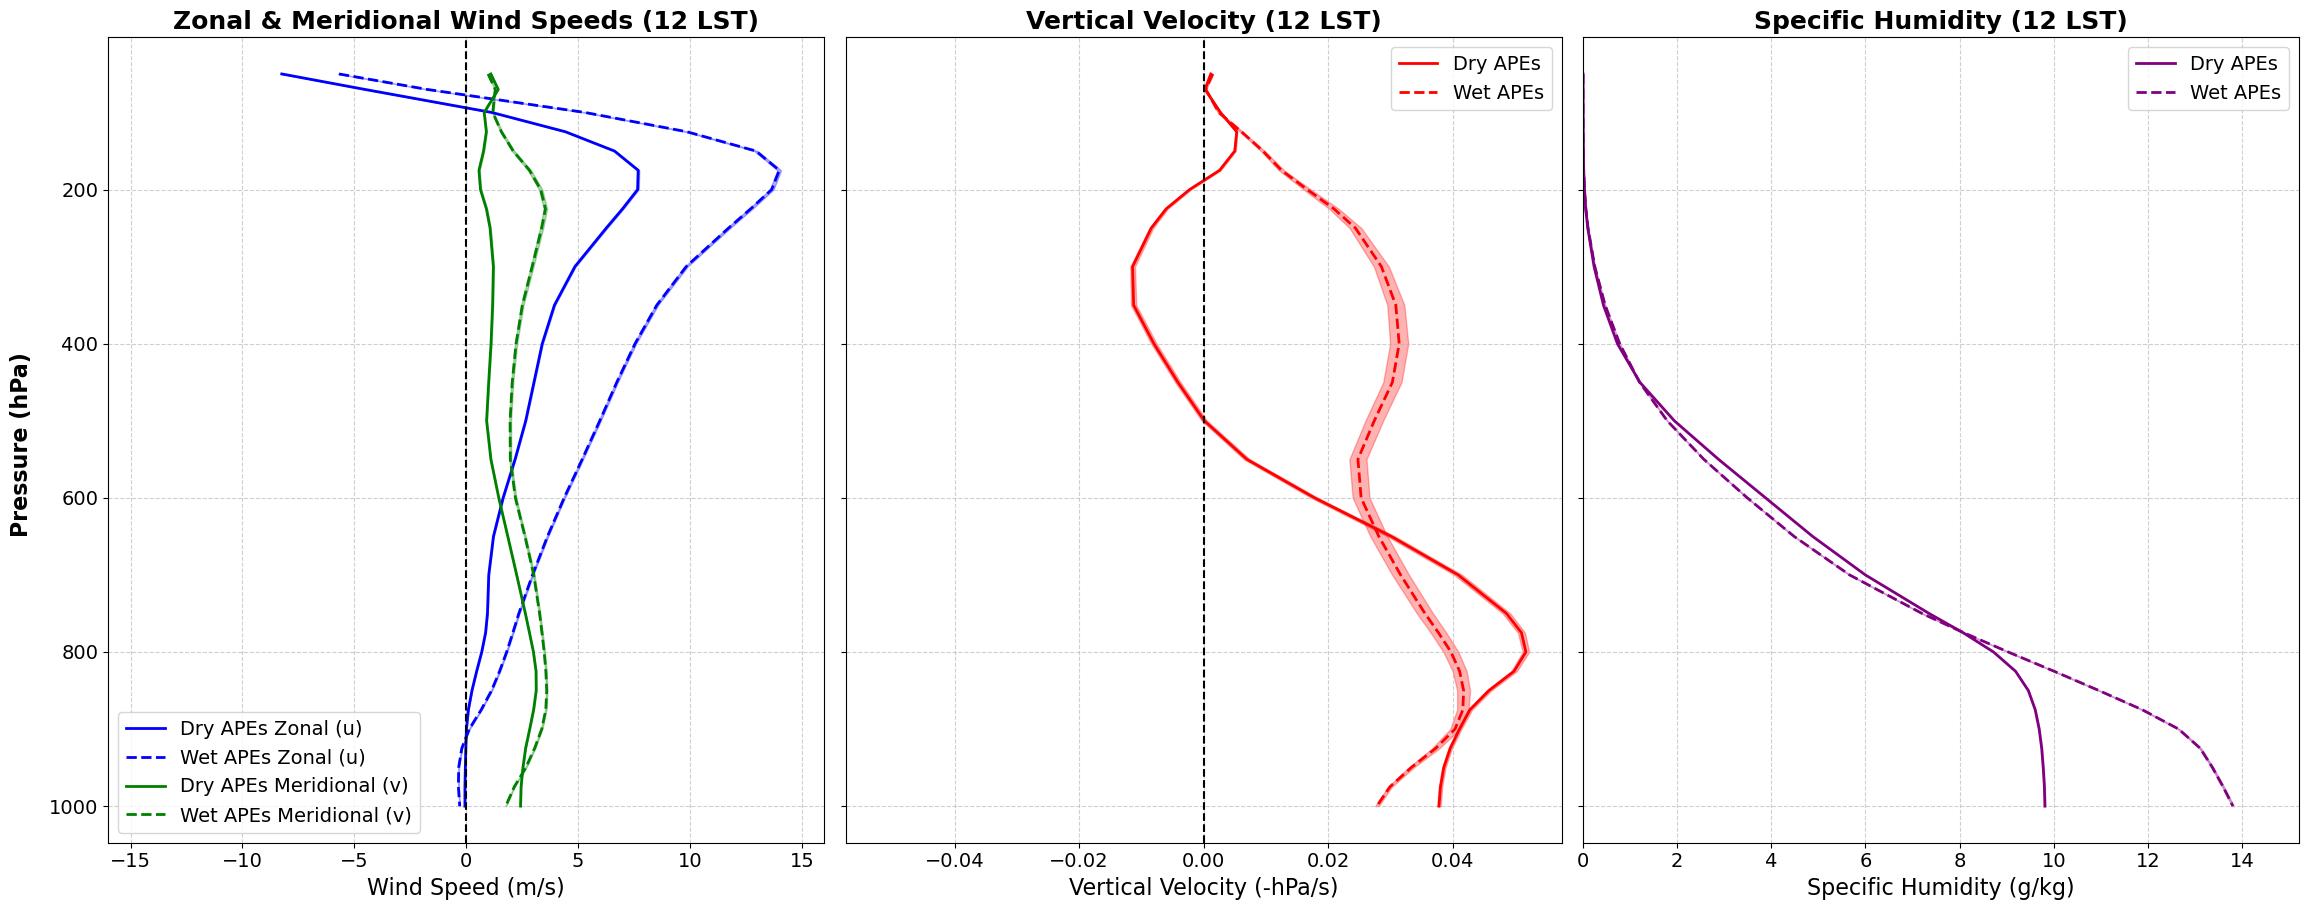

In [127]:
# -- Function to compute mean and 95% CI using nanmean/nanstd --

def compute_stats(profiles):
    """
    Computes mean and 95% confidence interval for a given set of profiles.

    Parameters:
        profiles: List or 2D array of shape (n_samples, n_levels)
    Returns:
        mean_profile (1D array): Mean across samples
        ci_profile (1D array): 95% confidence interval (margin of error)
    """
    profiles = np.array(profiles)  # Ensure it's an array
    
    mean_profile = np.nanmean(profiles, axis=0)  # Compute mean ignoring NaNs
    n_vals = np.sum(~np.isnan(profiles), axis=0)  # Number of valid values per level
    
    se = np.nanstd(profiles, axis=0, ddof=1) / np.sqrt(n_vals)  # Standard error

    # Compute t-values per level; if less than 2 valid samples, return NaN
    t_values = np.array([t.ppf(0.975, df=int(n)-1) if n > 1 else np.nan for n in n_vals])

    ci = t_values * se  # 95% confidence interval (margin of error)
    
    return mean_profile, ci

# -- Compute mean and confidence intervals for all variables --

# Zonal & Meridional Wind Speeds
dry_mean_zonal, dry_ci_zonal = compute_stats(dryapes['12lst_u_profile'].tolist())

dry_mean_merid, dry_ci_merid = compute_stats(dryapes['12lst_v_profile'].tolist())

wet_mean_zonal, wet_ci_zonal = compute_stats(wetapes['12lst_u_profile'].tolist())

wet_mean_merid, wet_ci_merid = compute_stats(wetapes['12lst_v_profile'].tolist())

# Vertical Velocity
dry_mean_vertical, dry_ci_vertical = compute_stats(dryapes['12lst_w_profile'].tolist())

wet_mean_vertical, wet_ci_vertical = compute_stats(wetapes['12lst_w_profile'].tolist())

# Specific Humidity (Convert from kg/kg to g/kg)
dry_mean_q, dry_ci_q = compute_stats(dryapes['12lst_q_profile'].tolist())

wet_mean_q, wet_ci_q = compute_stats(wetapes['12lst_q_profile'].tolist())

dry_mean_q_gkg = dry_mean_q * 1000
dry_ci_q_gkg = dry_ci_q * 1000
wet_mean_q_gkg = wet_mean_q * 1000
wet_ci_q_gkg = wet_ci_q * 1000

# Compute global x-axis limits
xlimit_horizontal = np.ceil(np.max([
    np.abs(dry_mean_zonal + dry_ci_zonal),
    np.abs(dry_mean_merid + dry_ci_merid),
    np.abs(wet_mean_zonal + wet_ci_zonal),
    np.abs(wet_mean_merid + wet_ci_merid),
]) * 1.1)

xlimit_vertical = np.max([
    np.abs(dry_mean_vertical + dry_ci_vertical),
    np.abs(wet_mean_vertical + wet_ci_vertical),
]) * 1.1

xlimit_q = np.max([
    np.abs(dry_mean_q_gkg + dry_ci_q_gkg),
    np.abs(wet_mean_q_gkg + wet_ci_q_gkg),
]) * 1.1

# Create a 1-row, 3-column figure layout
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)

## **Figure 1: Zonal & Meridional Wind Speeds for Dry & Wet APEs**
ax1 = axes[0]

# Plot Zonal Wind (u)
ax1.plot(dry_mean_zonal, pressure, label='Dry APEs Zonal (u)', linewidth=2, color='blue', linestyle='-')
ax1.fill_betweenx(pressure, dry_mean_zonal - dry_ci_zonal, dry_mean_zonal + dry_ci_zonal, color='blue', alpha=0.3)

ax1.plot(wet_mean_zonal, pressure, label='Wet APEs Zonal (u)', linewidth=2, color='blue', linestyle='--')
ax1.fill_betweenx(pressure, wet_mean_zonal - wet_ci_zonal, wet_mean_zonal + wet_ci_zonal, color='blue', alpha=0.3)

# Plot Meridional Wind (v)
ax1.plot(dry_mean_merid, pressure, label='Dry APEs Meridional (v)', linewidth=2, color='green', linestyle='-')
ax1.fill_betweenx(pressure, dry_mean_merid - dry_ci_merid, dry_mean_merid + dry_ci_merid, color='green', alpha=0.3)

ax1.plot(wet_mean_merid, pressure, label='Wet APEs Meridional (v)', linewidth=2, color='green', linestyle='--')
ax1.fill_betweenx(pressure, wet_mean_merid - wet_ci_merid, wet_mean_merid + wet_ci_merid, color='green', alpha=0.3)

# Formatting
ax1.set_xlim(-xlimit_horizontal, xlimit_horizontal)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Wind Speed (m/s)', fontsize=16)
ax1.set_title('Zonal & Meridional Wind Speeds (12 LST)', fontsize=18, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=14)
ax1.tick_params(axis='both', labelsize=14)


## **Figure 2: Vertical Velocity for Dry & Wet APEs**
ax2 = axes[1]

# Plot Vertical Velocity (w)
ax2.plot(dry_mean_vertical, pressure, label='Dry APEs', linewidth=2, color='red', linestyle='-')
ax2.fill_betweenx(pressure, dry_mean_vertical - dry_ci_vertical, dry_mean_vertical + dry_ci_vertical, color='red', alpha=0.3)

ax2.plot(wet_mean_vertical, pressure, label='Wet APEs', linewidth=2, color='red', linestyle='--')
ax2.fill_betweenx(pressure, wet_mean_vertical - wet_ci_vertical, wet_mean_vertical + wet_ci_vertical, color='red', alpha=0.3)

# Formatting
ax2.set_xlim(-xlimit_vertical, xlimit_vertical)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax2.set_xlabel(r'Vertical Velocity (-hPa/s)', fontsize=16)
ax2.set_title('Vertical Velocity (12 LST)', fontsize=18, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=14)
ax2.tick_params(axis='both', labelsize=14)


## **Figure 3: Specific Humidity (q) for Dry & Wet APEs**
ax3 = axes[2]

# Plot Specific Humidity (q)
ax3.plot(dry_mean_q_gkg, pressure, label='Dry APEs', linewidth=2, color='purple', linestyle='-')
ax3.fill_betweenx(pressure, dry_mean_q_gkg - dry_ci_q_gkg, dry_mean_q_gkg + dry_ci_q_gkg, color='purple', alpha=0.3)

ax3.plot(wet_mean_q_gkg, pressure, label='Wet APEs', linewidth=2, color='purple', linestyle='--')
ax3.fill_betweenx(pressure, wet_mean_q_gkg - wet_ci_q_gkg, wet_mean_q_gkg + wet_ci_q_gkg, color='purple', alpha=0.3)

# Formatting
ax3.set_xlim(0, xlimit_q)
ax3.set_xlabel(r'Specific Humidity (g/kg)', fontsize=16)
ax3.set_title('Specific Humidity (12 LST)', fontsize=18, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend(fontsize=14)
ax3.tick_params(axis='both', labelsize=14)

## **Overall Figure Formatting**
fig.text(0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])

plt.show()


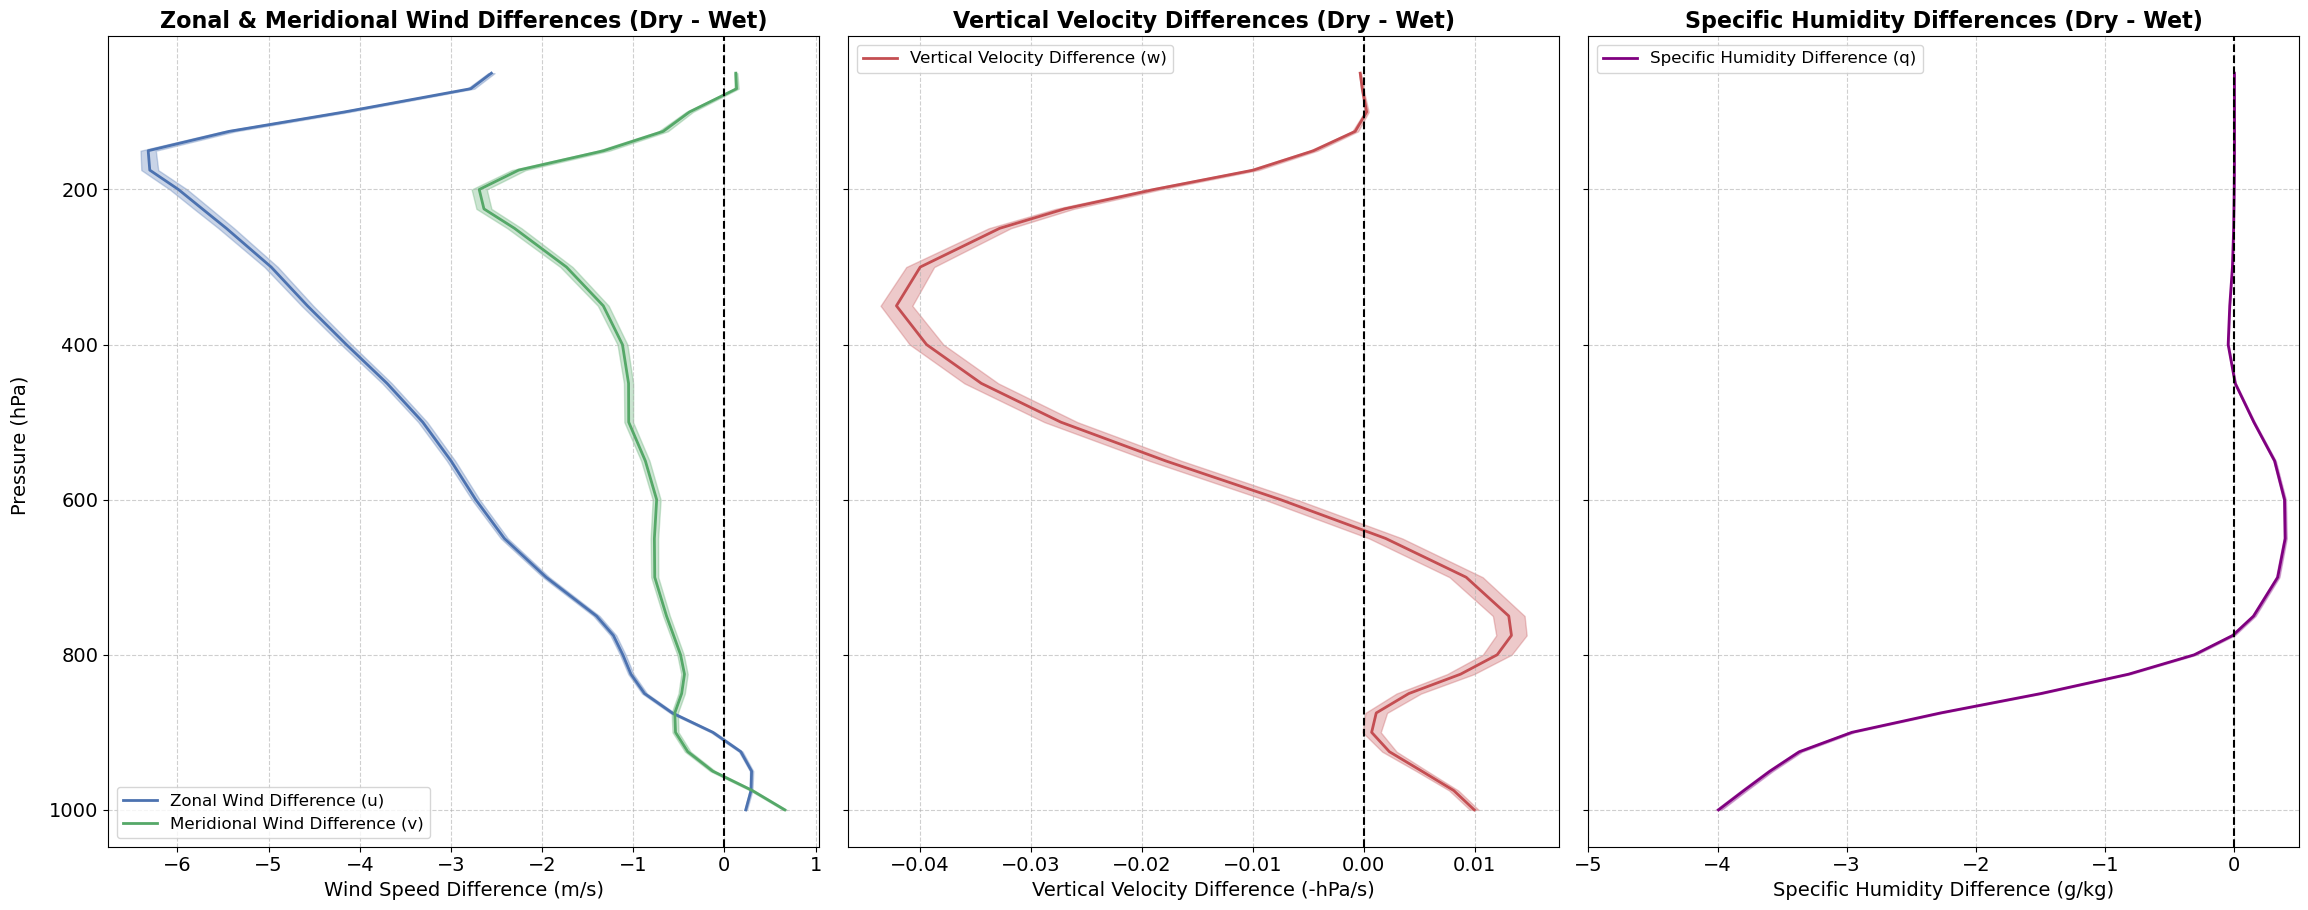

In [128]:
# Compute Differences (Dry APEs - Wet APEs)
diff_mean_zonal = dry_mean_zonal - wet_mean_zonal

diff_ci_zonal = np.sqrt(dry_ci_zonal**2 + wet_ci_zonal**2)  # Combined CI

diff_mean_merid = dry_mean_merid - wet_mean_merid
diff_ci_merid = np.sqrt(dry_ci_merid**2 + wet_ci_merid**2)

diff_mean_vertical = dry_mean_vertical - wet_mean_vertical
diff_ci_vertical = np.sqrt(dry_ci_vertical**2 + wet_ci_vertical**2)

diff_mean_q_gkg = (dry_mean_q - wet_mean_q) * 1000  # Convert to g/kg
diff_ci_q_gkg = np.sqrt(dry_ci_q**2 + wet_ci_q**2) * 1000  # Convert to g/kg

# Create a 1-row, 3-column figure layout
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)

## **Figure 1: Zonal & Meridional Wind Differences**
ax1 = axes[0]

# Plot Zonal Wind Difference
ax1.plot(diff_mean_zonal, pressure, label='Zonal Wind Difference (u)', linewidth=2, color=color_zonal)
ax1.fill_betweenx(pressure, diff_mean_zonal - diff_ci_zonal, diff_mean_zonal + diff_ci_zonal,
                   color=color_zonal, alpha=0.3)

# Plot Meridional Wind Difference
ax1.plot(diff_mean_merid, pressure, label='Meridional Wind Difference (v)', linewidth=2, color=color_merid)
ax1.fill_betweenx(pressure, diff_mean_merid - diff_ci_merid, diff_mean_merid + diff_ci_merid,
                   color=color_merid, alpha=0.3)

# Formatting
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Wind Speed Difference (m/s)', fontsize=14)
ax1.set_title('Zonal & Meridional Wind Differences (Dry - Wet)', fontsize=16, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', labelsize=14)


## **Figure 2: Vertical Velocity Differences**
ax2 = axes[1]

# Plot Vertical Velocity Difference
ax2.plot(diff_mean_vertical, pressure, label='Vertical Velocity Difference (w)', linewidth=2, color=color_vertical)
ax2.fill_betweenx(pressure, diff_mean_vertical - diff_ci_vertical, diff_mean_vertical + diff_ci_vertical,
                   color=color_vertical, alpha=0.3)

# Formatting
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax2.set_xlabel(r'Vertical Velocity Difference (-hPa/s)', fontsize=14)
ax2.set_title('Vertical Velocity Differences (Dry - Wet)', fontsize=16, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', labelsize=14)


## **Figure 3: Specific Humidity Differences**
ax3 = axes[2]

# Plot Specific Humidity Difference
ax3.plot(diff_mean_q_gkg, pressure, label='Specific Humidity Difference (q)', linewidth=2, color='purple')
ax3.fill_betweenx(pressure, diff_mean_q_gkg - diff_ci_q_gkg, diff_mean_q_gkg + diff_ci_q_gkg,
                   color='purple', alpha=0.3)

ax3.set_xlim(-5,0.5)

# Formatting
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax3.set_xlabel(r'Specific Humidity Difference (g/kg)', fontsize=14)
ax3.set_title('Specific Humidity Differences (Dry - Wet)', fontsize=16, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend(fontsize=12)
ax3.tick_params(axis='both', labelsize=14)

## **Overall Figure Formatting**
fig.text(0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize=14)
plt.gca().invert_yaxis()

plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])

plt.show()
